In [396]:
import sys, os
sys.path.append(os.path.abspath("../src"))

from nets import MLP
from burger_ground_truth import burgers_ground_truth_fd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Burger's equation

Use the viscous form
\begin{align}
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} &= \nu \dfrac{\partial^2 u}{\partial x^2},\nonumber\\
u(0,x) &= -\sin(\pi x),\nonumber\\
u(t,x) &= 0 \,\,\,\,\,\,\hbox{at}\,\,\,\,\,\,x\in\{-1,1\},
\end{align}
where $u(t,x)$ represnet a velocity field. When $\nu > 0$, the solutions are smooth, balancing nonlinearity and diffusion. In the limit $\nu \rightarrow 0$, shock waves can form, making Burgers’ equation a prototypical model to study shock formation and related phenomena in fluid dynamics [1].

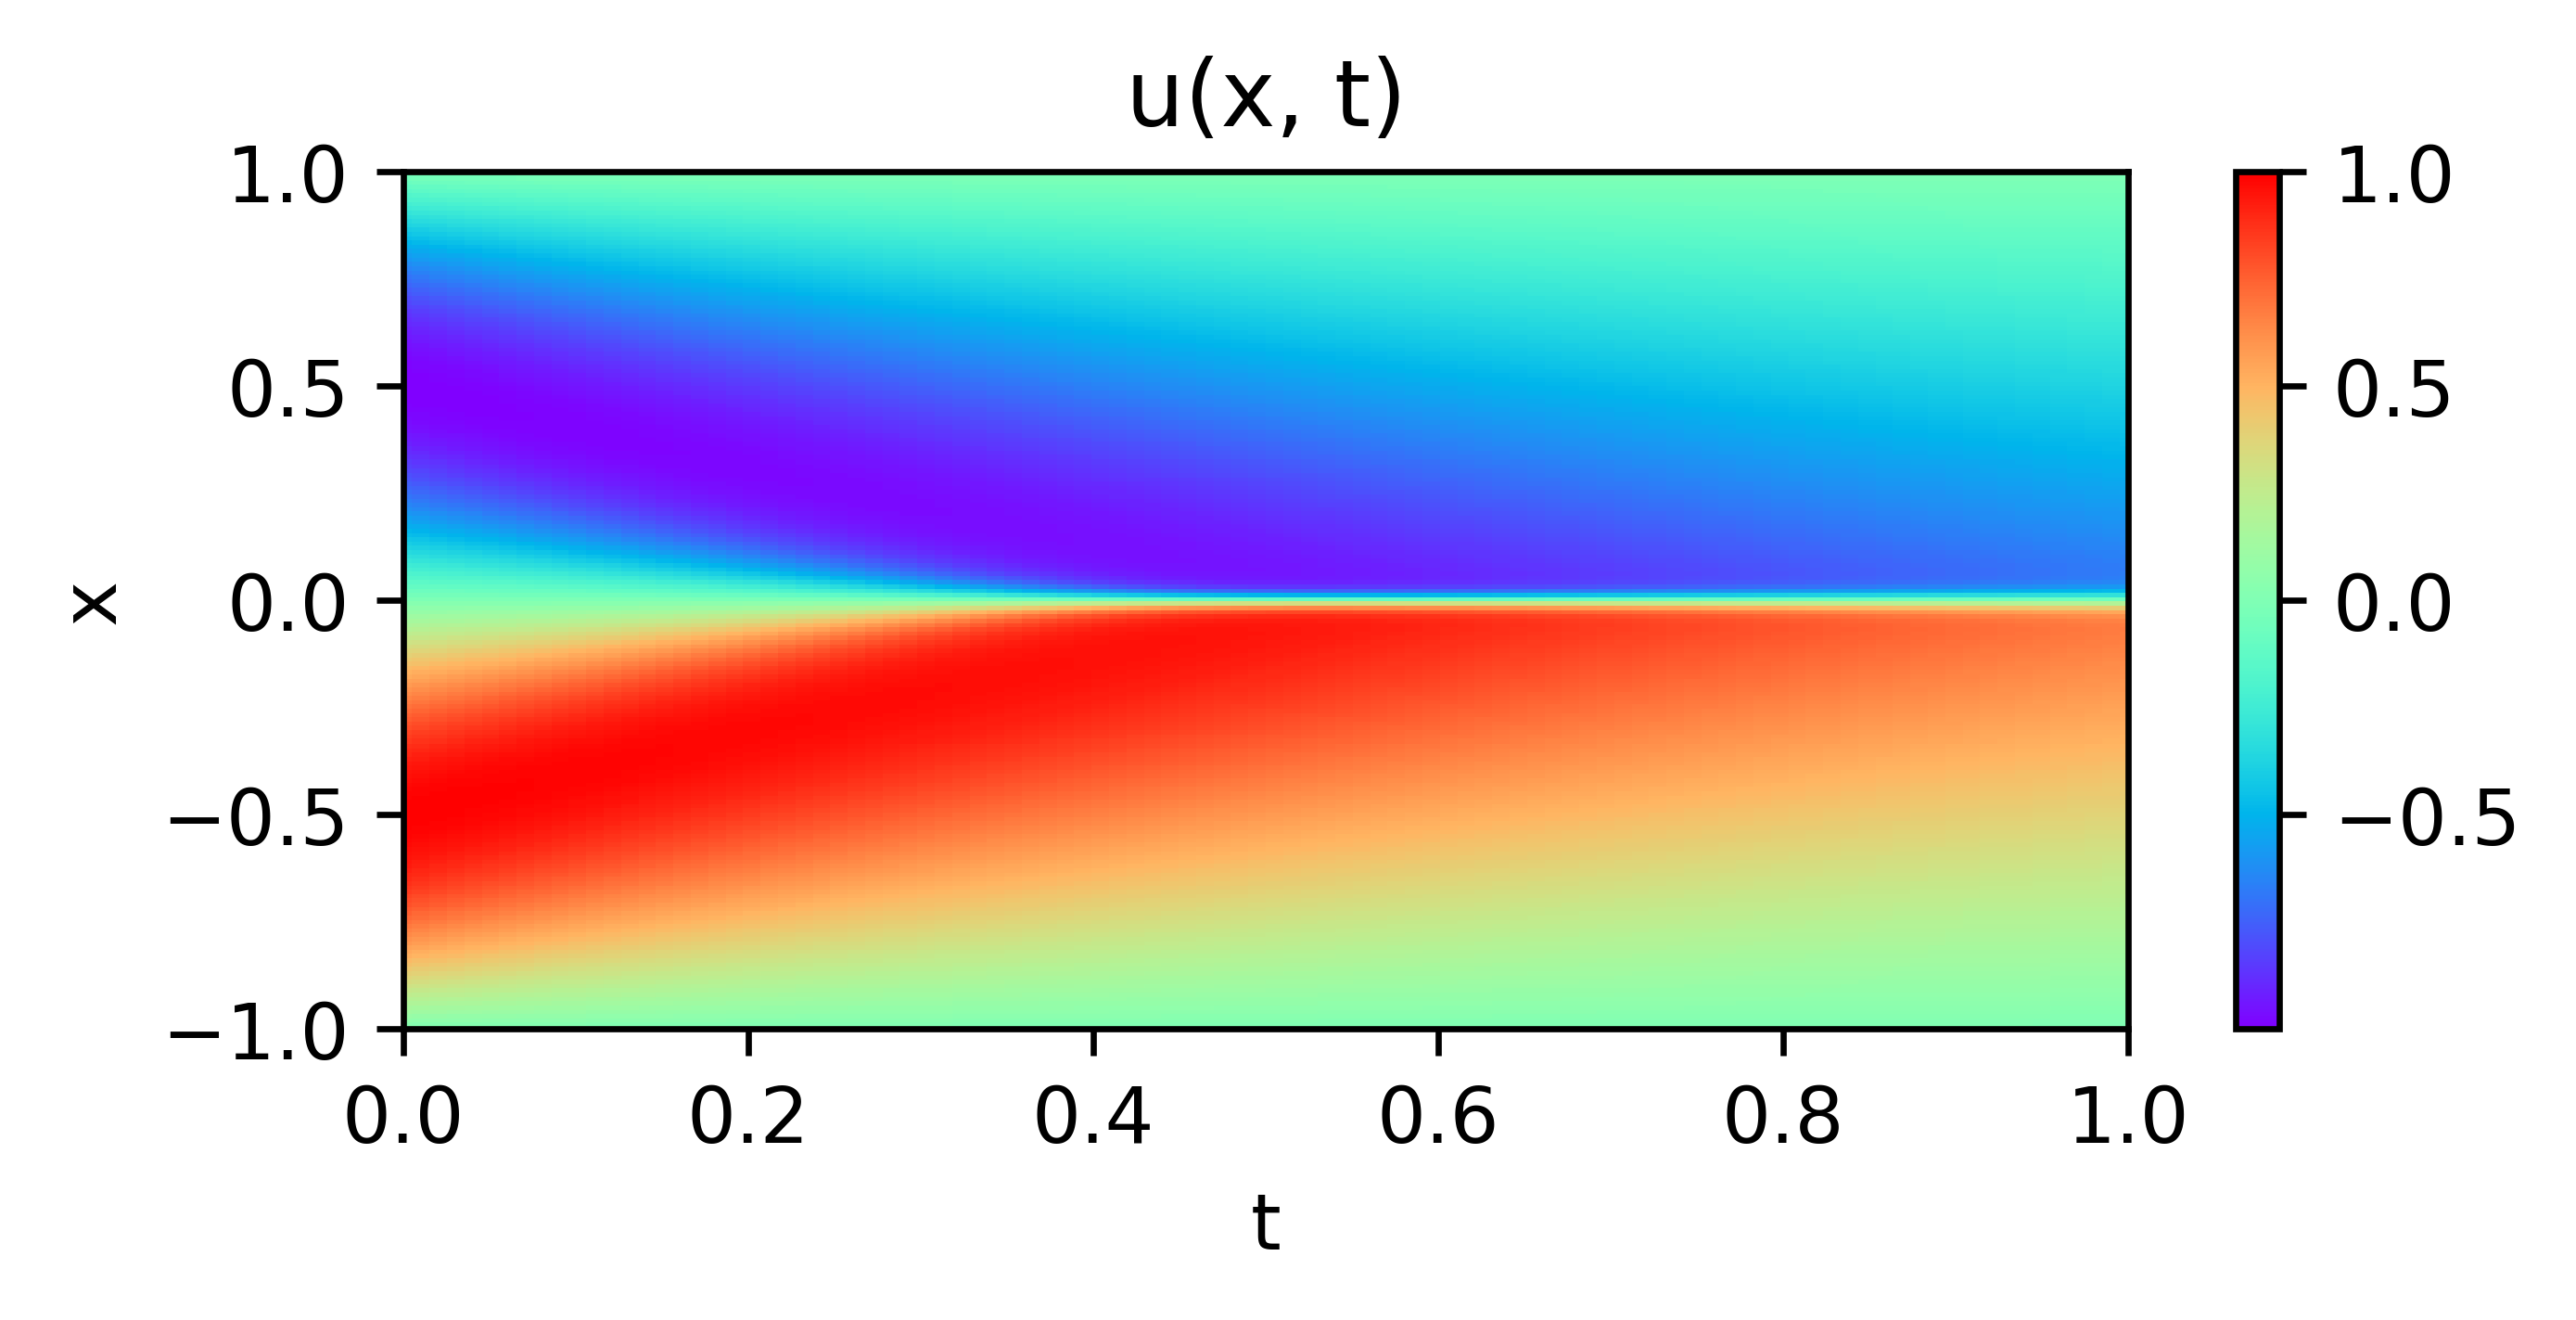

In [397]:
# Ground truth data using finite differences
x, t, U = burgers_ground_truth_fd()  # U: (Nt, Nx)

n, m = 100, 200

t_idx = np.linspace(0, len(t)-1, n).astype(int)
x_idx = np.linspace(0, len(x)-1, m).astype(int)

T = t[t_idx]            # (n,)
X = x[x_idx]            # (m,)
S = U[t_idx][:, x_idx]  # (n, m)

X0, T0 = np.meshgrid(X, T)  # (n, m)
plt.figure(figsize=(5, 2), dpi=600)
plt.pcolormesh(T0, X0, S, shading="auto", cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., 1.0)
plt.ylim(-1, 1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.show()

In [398]:
# indice t = 0.4
np.argmin(np.abs(t-0.6))


np.int64(3599)

# PINN inverse 

In [399]:
net = MLP(2, 1, 3, 20, activation_fn = nn.Tanh())

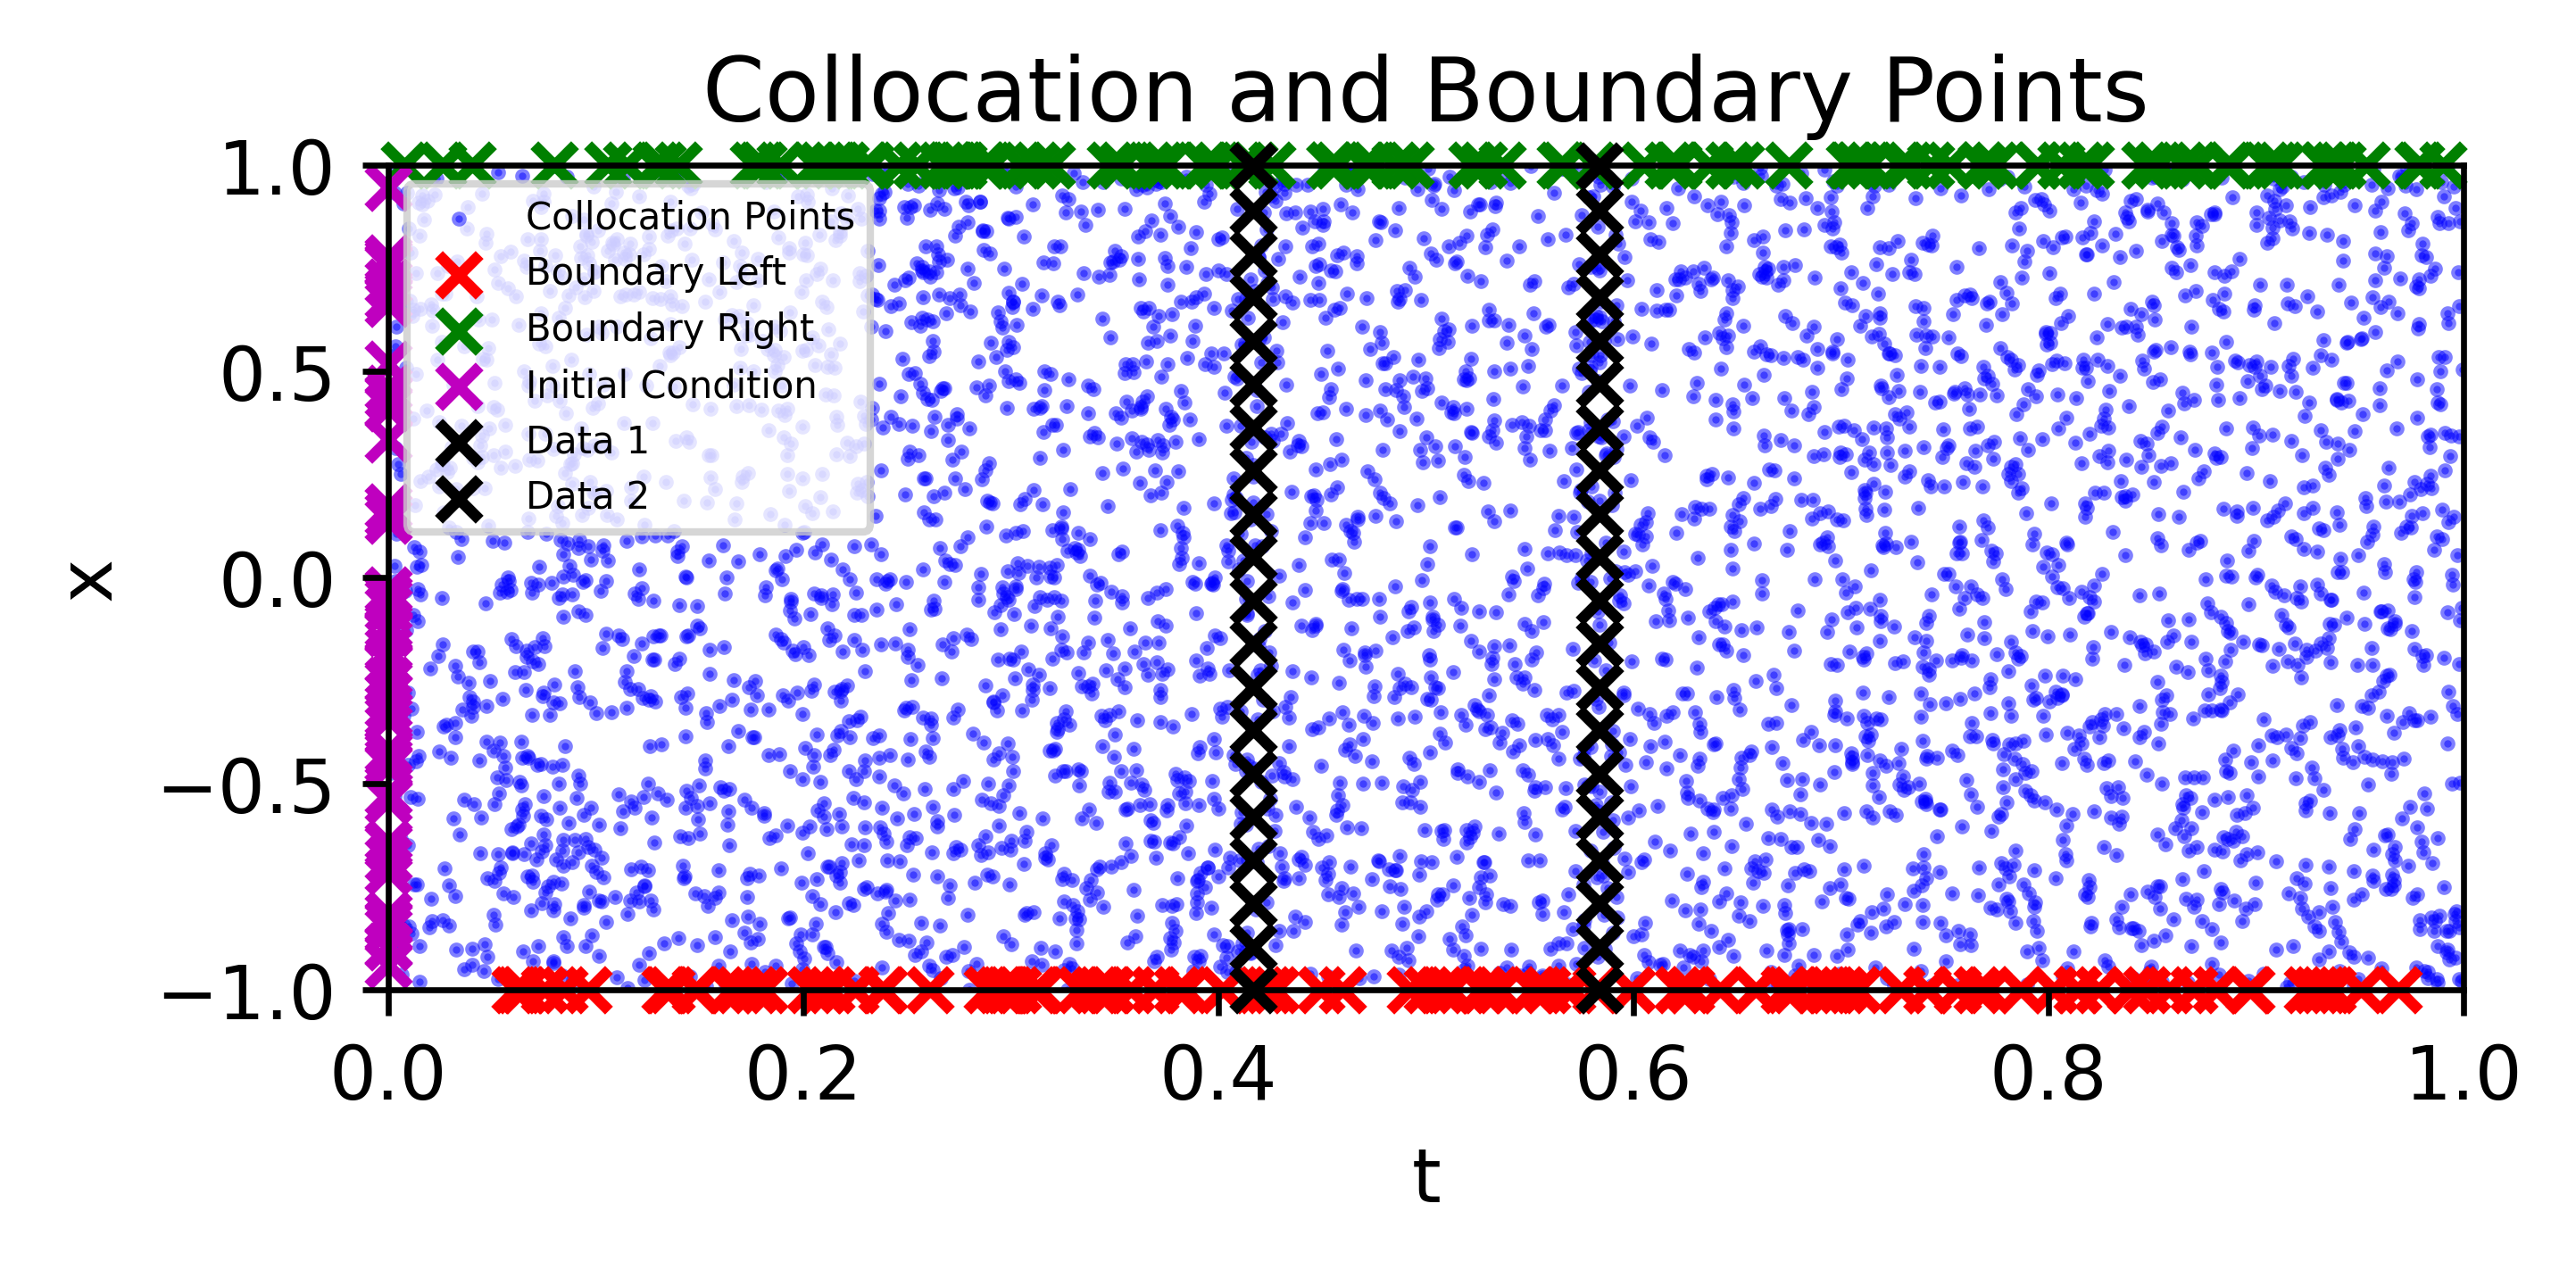

In [400]:
# Boundary conditions
t_b_l = torch.rand(100, 1, dtype=torch.float32)  # (100, 1)
x_b_l = torch.tensor(-1.0).repeat(100, 1)  # (100, 1)

t_b_r = torch.rand(100, 1, dtype=torch.float32)  # (100, 1)
x_b_r = torch.tensor(1.0).repeat(100, 1)  # (100, 1)

x_i = 2*torch.rand(50, 1, dtype=torch.float32) - 1.0  # (100, 1)
t_i = torch.zeros_like(x_i)  # (100, 1)
u_i = - torch.sin(np.pi * x_i)  # (100, 1)

# colocation points 
n_f = 4000
x_c = 2*torch.rand(n_f, 1, dtype=torch.float32) - 1.0
t_c = torch.rand(n_f, 1, dtype=torch.float32)
x_c.requires_grad_(True)
t_c.requires_grad_(True)

#############################################################################
# Data points
x_idx_data = np.linspace(0, len(x)-1, 20).astype(int)
X_data = torch.tensor(x[x_idx_data], dtype=torch.float32).reshape(-1,1)

t_data_1 = torch.tensor(t[2500], dtype=torch.float32).repeat(20, 1)
t_data_2 = torch.tensor(t[3500], dtype=torch.float32).repeat(20, 1)

# X_data
U_data_1 = torch.tensor(U[2500][x_idx_data], dtype=torch.float32).reshape(-1,1)
U_data_2 = torch.tensor(U[3500][x_idx_data], dtype=torch.float32).reshape(-1,1)

# Noise to data
def add_hetero_noise_abs(y, zeta=0.25, eps=1e-8):
    sigma = zeta * (y.abs() + eps)   # std siempre positiva
    return y + sigma * torch.randn_like(y)

U_data_1_noisy = add_hetero_noise_abs(U_data_1, zeta=0.40)
U_data_2_noisy = add_hetero_noise_abs(U_data_2, zeta=0.40)



#############################################################################

plt.figure(figsize=(5, 2), dpi=600)

plt.scatter(t_c.detach().numpy(), x_c.detach().numpy(), s=1, alpha=0.5, c='b', label='Collocation Points')

plt.scatter(t_b_l.numpy(), x_b_l.numpy(),
            s=30, c='r', marker='x', linewidths=1.5, clip_on=False, label='Boundary Left')

plt.scatter(t_b_r.numpy(), x_b_r.numpy(),
            s=30, c='g', marker='x', linewidths=1.5, clip_on=False, label='Boundary Right')

plt.scatter(t_i.numpy(), x_i.numpy(),
            s=30, c='m', marker='x', linewidths=1.5, clip_on=False, label='Initial Condition')

plt.scatter(t_data_1.numpy(), X_data.numpy(),
            s=30, c='black', marker='x', linewidths=1.5, clip_on=False, label='Data 1')

plt.scatter(t_data_2.numpy(), X_data.numpy(),
            s=30, c='black', marker='x', linewidths=1.5, clip_on=False, label='Data 2')


plt.title('Collocation and Boundary Points')
plt.legend(fontsize=5)
plt.xlim(0, 1)
plt.ylim(-1.0, 1.0)   # NO se agranda
plt.xlabel('t')
plt.ylabel('x')
plt.show()

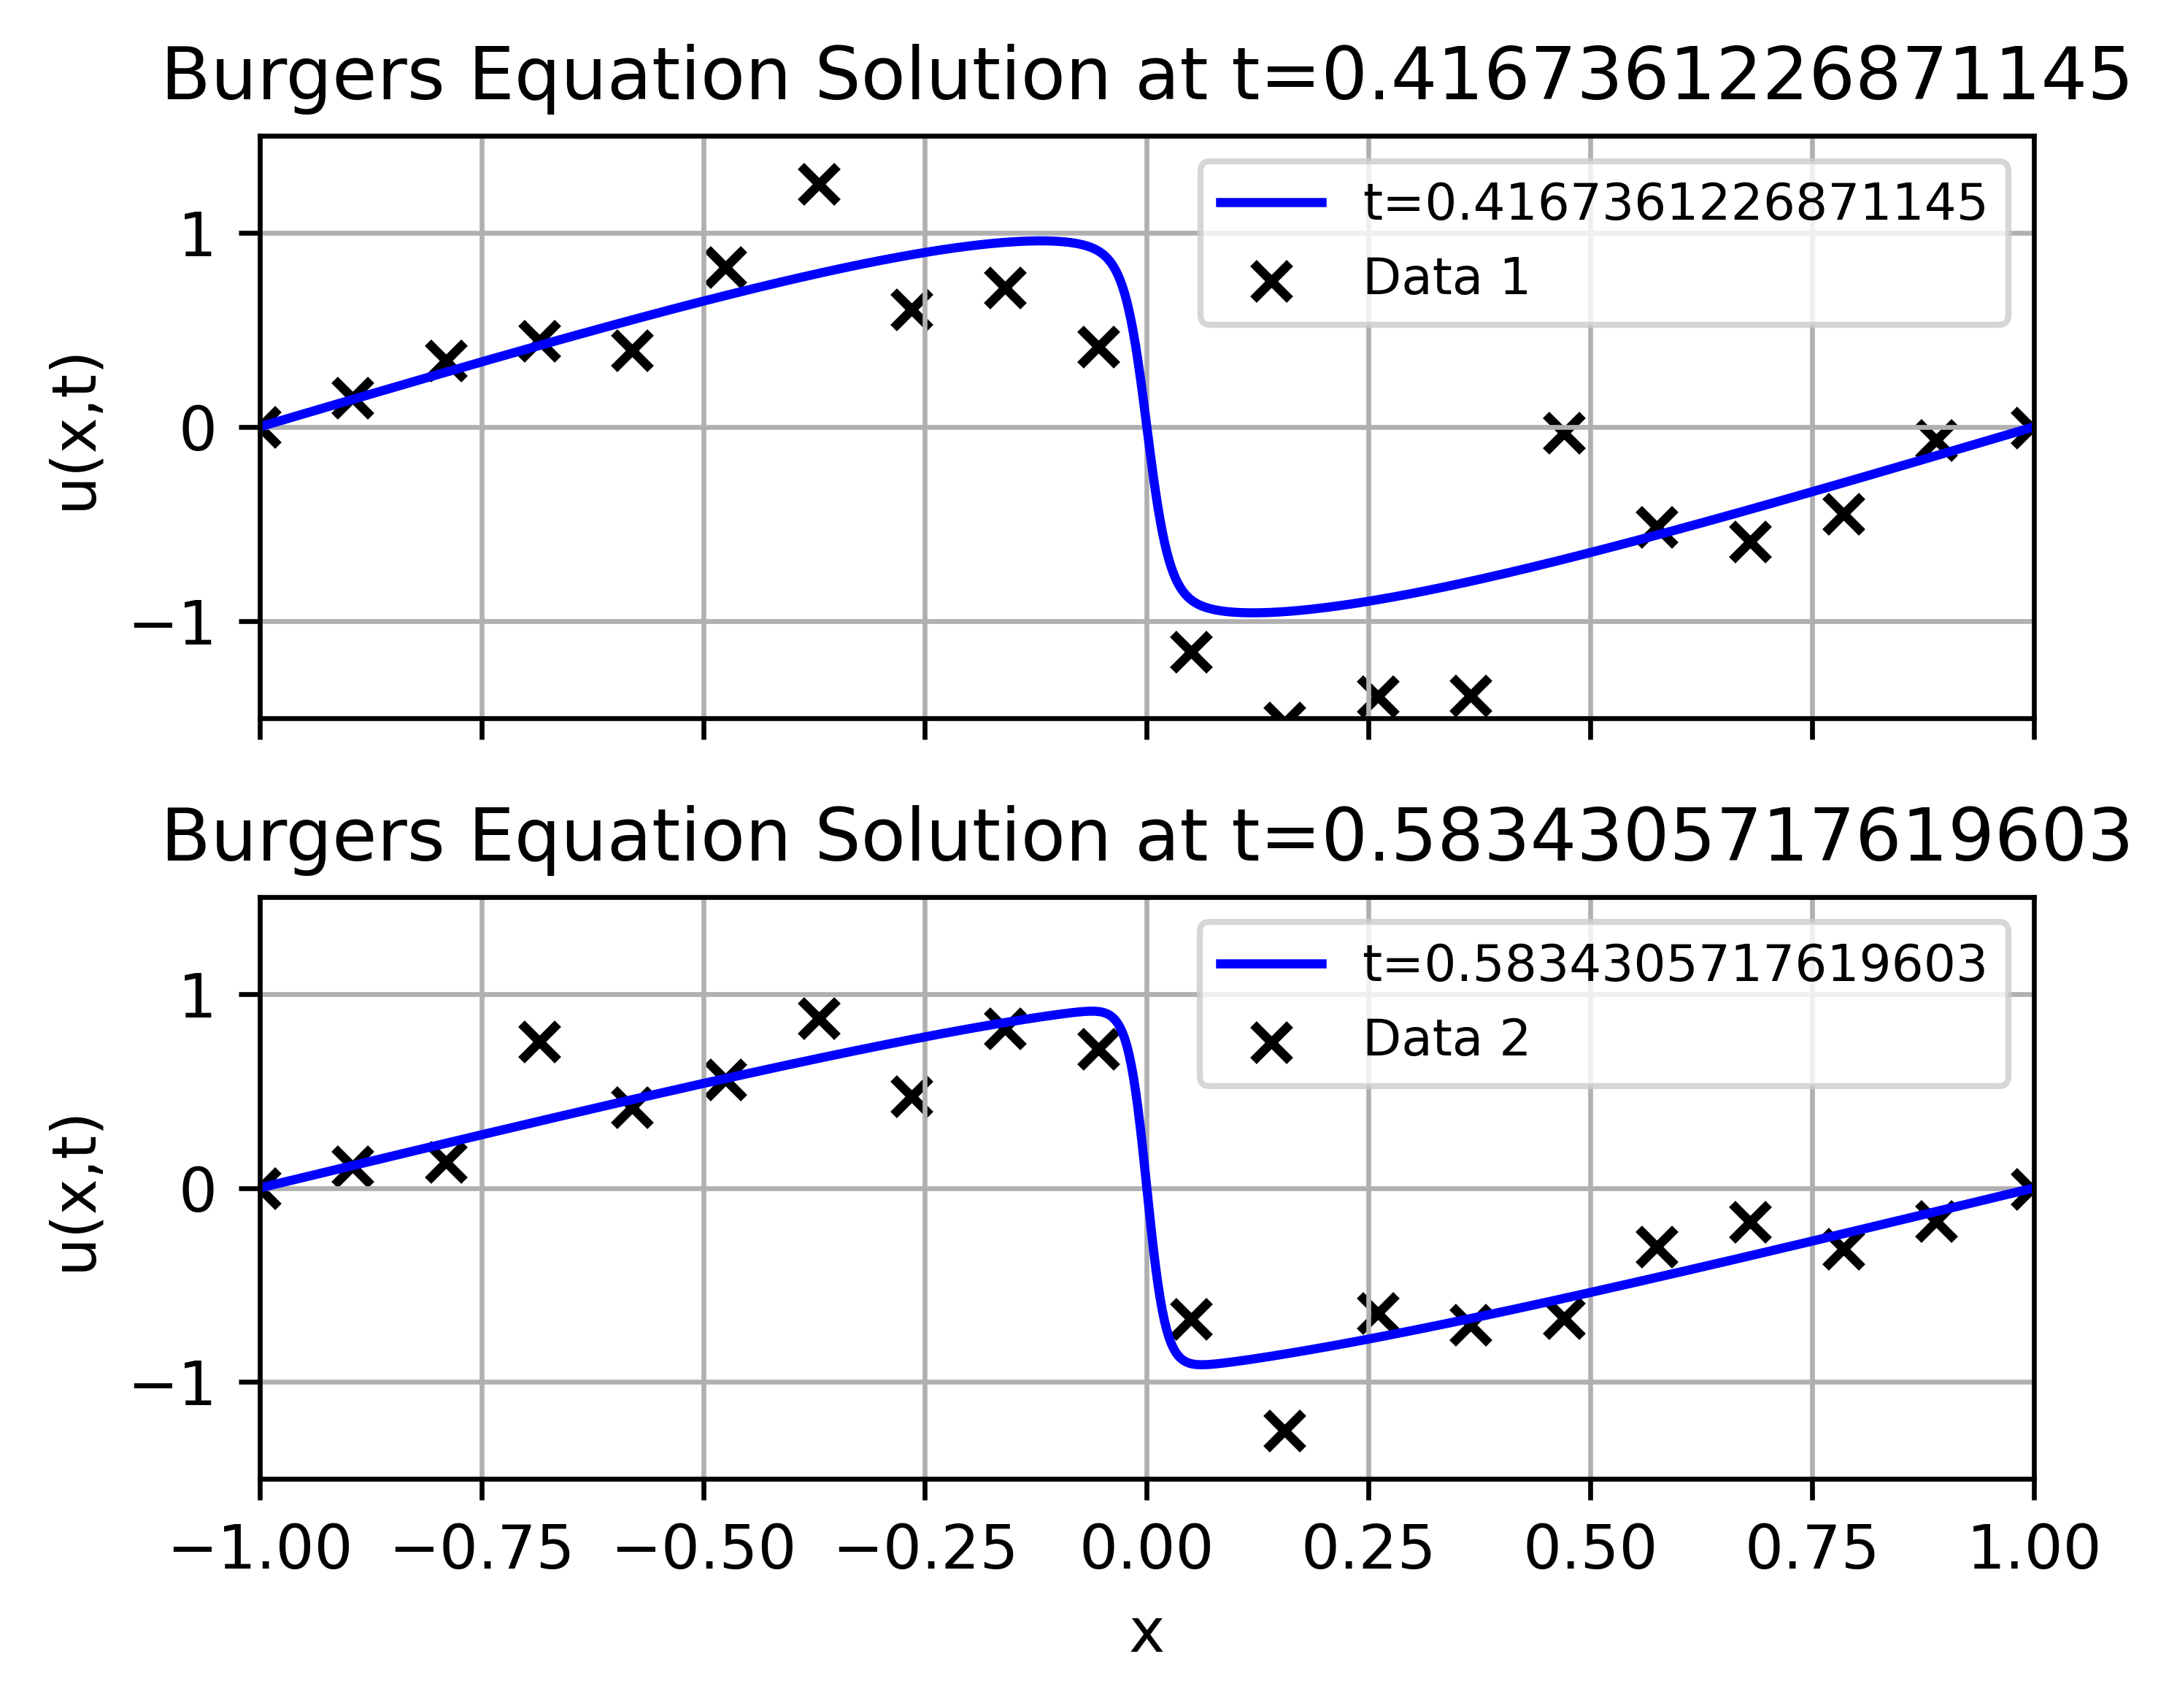

In [401]:
tp1 = t[2500]
tp2 = t[3500]

i1 = np.argmin(np.abs(t - tp1))
i2 = np.argmin(np.abs(t - tp2))

x_sample = x
u1 = U[i1, :]
u2 = U[i2, :]



fig, ax = plt.subplots(2, 1, figsize=(5, 4), dpi=600, sharex=True, sharey=True)

ax[0].plot(x_sample, u1, 'b-', label=f't={tp1}')
ax[0].scatter(X_data.numpy(), U_data_1_noisy.numpy(),  marker = 'x', color ='black', label='Data 1')
ax[0].set_title(f'Burgers Equation Solution at t={tp1}')
ax[0].set_ylabel('u(x,t)')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1.5, 1.5)
ax[0].grid(True)
ax[0].legend(loc='upper right', fontsize = 'small')

ax[1].plot(x_sample, u2, 'b-', label=f't={tp2}')
ax[1].scatter(X_data.numpy(), U_data_2_noisy.numpy(), marker = 'x', color ='black', label='Data 2')
ax[1].set_title(f'Burgers Equation Solution at t={tp2}')
ax[1].set_xlabel('x')
ax[1].set_ylabel('u(x,t)')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1.5, 1.5)
ax[1].grid(True)
ax[1].legend(loc='upper right', fontsize = 'small')

plt.tight_layout()
plt.show()

## Loss terms

In [402]:
nu = nn.Parameter(torch.tensor(0.1, dtype=torch.float32), requires_grad=True)

In [403]:
def burgers_residual():
    u = net(x_c, t_c)  
    u_t = torch.autograd.grad(u, t_c, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_c, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_c, torch.ones_like(u_x), create_graph=True)[0]
    r = u_t + u*u_x - nu*u_xx
    return torch.mean(r**2)

In [404]:
x_t = torch.tensor(np.random.rand(10, 1), dtype=torch.float32).requires_grad_(True)
t_t = torch.tensor(np.random.rand(10, 1), dtype=torch.float32).requires_grad_(True)

#burgers_residual()

In [405]:
def initial_condition_loss():
    u_pred = net(x_i, t_i)
    return torch.mean((u_pred - u_i)**2)

In [406]:
def boundary_condition_loss():
    u_b_l = net(x_b_l, t_b_l)
    u_b_r = net(x_b_r, t_b_r)
    return torch.mean(u_b_l**2) + torch.mean(u_b_r**2)

In [407]:
def data_loss():
    u_data_1 = net(X_data, t_data_1)
    u_data_2 = net(X_data, t_data_2)
    r_data_1 = torch.mean((u_data_1 - U_data_1)**2)
    r_data_2 = torch.mean((u_data_2 - U_data_2)**2)
    return r_data_1 + r_data_2

In [408]:
def compute_loss():
    res_loss = burgers_residual()
    ic_loss = initial_condition_loss()
    bc_loss = boundary_condition_loss()
    data_loss_value = data_loss()
    total_loss = data_loss_value + res_loss + ic_loss + bc_loss
    return total_loss, data_loss_value, res_loss, ic_loss, bc_loss

# Training

In [409]:
X_test = torch.tensor(X0, dtype=torch.float32).reshape(-1, 1)
T_test = torch.tensor(T0, dtype=torch.float32).reshape(-1, 1)
U_true = torch.tensor(S.flatten(), dtype=torch.float32).reshape(-1, 1)

def relative_error():
    u_pred = net(X_test, T_test)
    return torch.norm(u_pred - U_true) / torch.norm(U_true)

#relative_error()

In [410]:
dict = {
    "data_loss": [],
    "res_loss": [],
    "ic_loss": [],
    "bc_loss": [],
    "total_loss": [],
    "rel_error": [],
    "nu_value": []
}

In [411]:
# tasa de aprendizaje distinta para pesos y para parametro nu
optimizer = torch.optim.Adam([
    {"params": net.parameters(), "lr": 1e-3},
    {"params": [nu], "lr": 1e-3}
])
# optimizer.param_groups[1]

In [412]:
epoch = 10000
for ep in range(epoch):
    optimizer.zero_grad()
    total_loss, data_loss_value, res_loss, ic_loss, bc_loss = compute_loss()
    total_loss.backward()
    optimizer.step()

    dict["data_loss"].append(data_loss_value.item())
    dict["res_loss"].append(res_loss.item())
    dict["ic_loss"].append(ic_loss.item())
    dict["bc_loss"].append(bc_loss.item())
    dict["total_loss"].append(total_loss.item())
    dict["nu_value"].append(nu.item())

    if ep % 10 == 0:
        rel_err = relative_error().item()
        dict["rel_error"].append(rel_err)

    if ep % 1000 == 0:
        print(f"Epoch {ep}, nu: {nu.item():.6f} Relative Error: {rel_err:.6f}, Total Loss: {total_loss.item():.6f}, Residual Loss: {res_loss.item():.6f}, IC Loss: {ic_loss.item():.6f}, BC Loss: {bc_loss.item():.6f}")

Epoch 0, nu: 0.099000 Relative Error: 1.012403, Total Loss: 1.312113, Residual Loss: 0.000183, IC Loss: 0.477137, BC Loss: 0.050532
Epoch 1000, nu: 0.017439 Relative Error: 0.079312, Total Loss: 0.020924, Residual Loss: 0.012020, IC Loss: 0.002938, BC Loss: 0.002097
Epoch 2000, nu: 0.015788 Relative Error: 0.052226, Total Loss: 0.006893, Residual Loss: 0.004494, IC Loss: 0.000804, BC Loss: 0.000465
Epoch 3000, nu: 0.014487 Relative Error: 0.041351, Total Loss: 0.005589, Residual Loss: 0.004302, IC Loss: 0.000387, BC Loss: 0.000209
Epoch 4000, nu: 0.013954 Relative Error: 0.035308, Total Loss: 0.002801, Residual Loss: 0.002084, IC Loss: 0.000242, BC Loss: 0.000135
Epoch 5000, nu: 0.013526 Relative Error: 0.031352, Total Loss: 0.002107, Residual Loss: 0.001555, IC Loss: 0.000202, BC Loss: 0.000099
Epoch 6000, nu: 0.013193 Relative Error: 0.029770, Total Loss: 0.001825, Residual Loss: 0.001262, IC Loss: 0.000191, BC Loss: 0.000046
Epoch 7000, nu: 0.012842 Relative Error: 0.025565, Total L

# Results

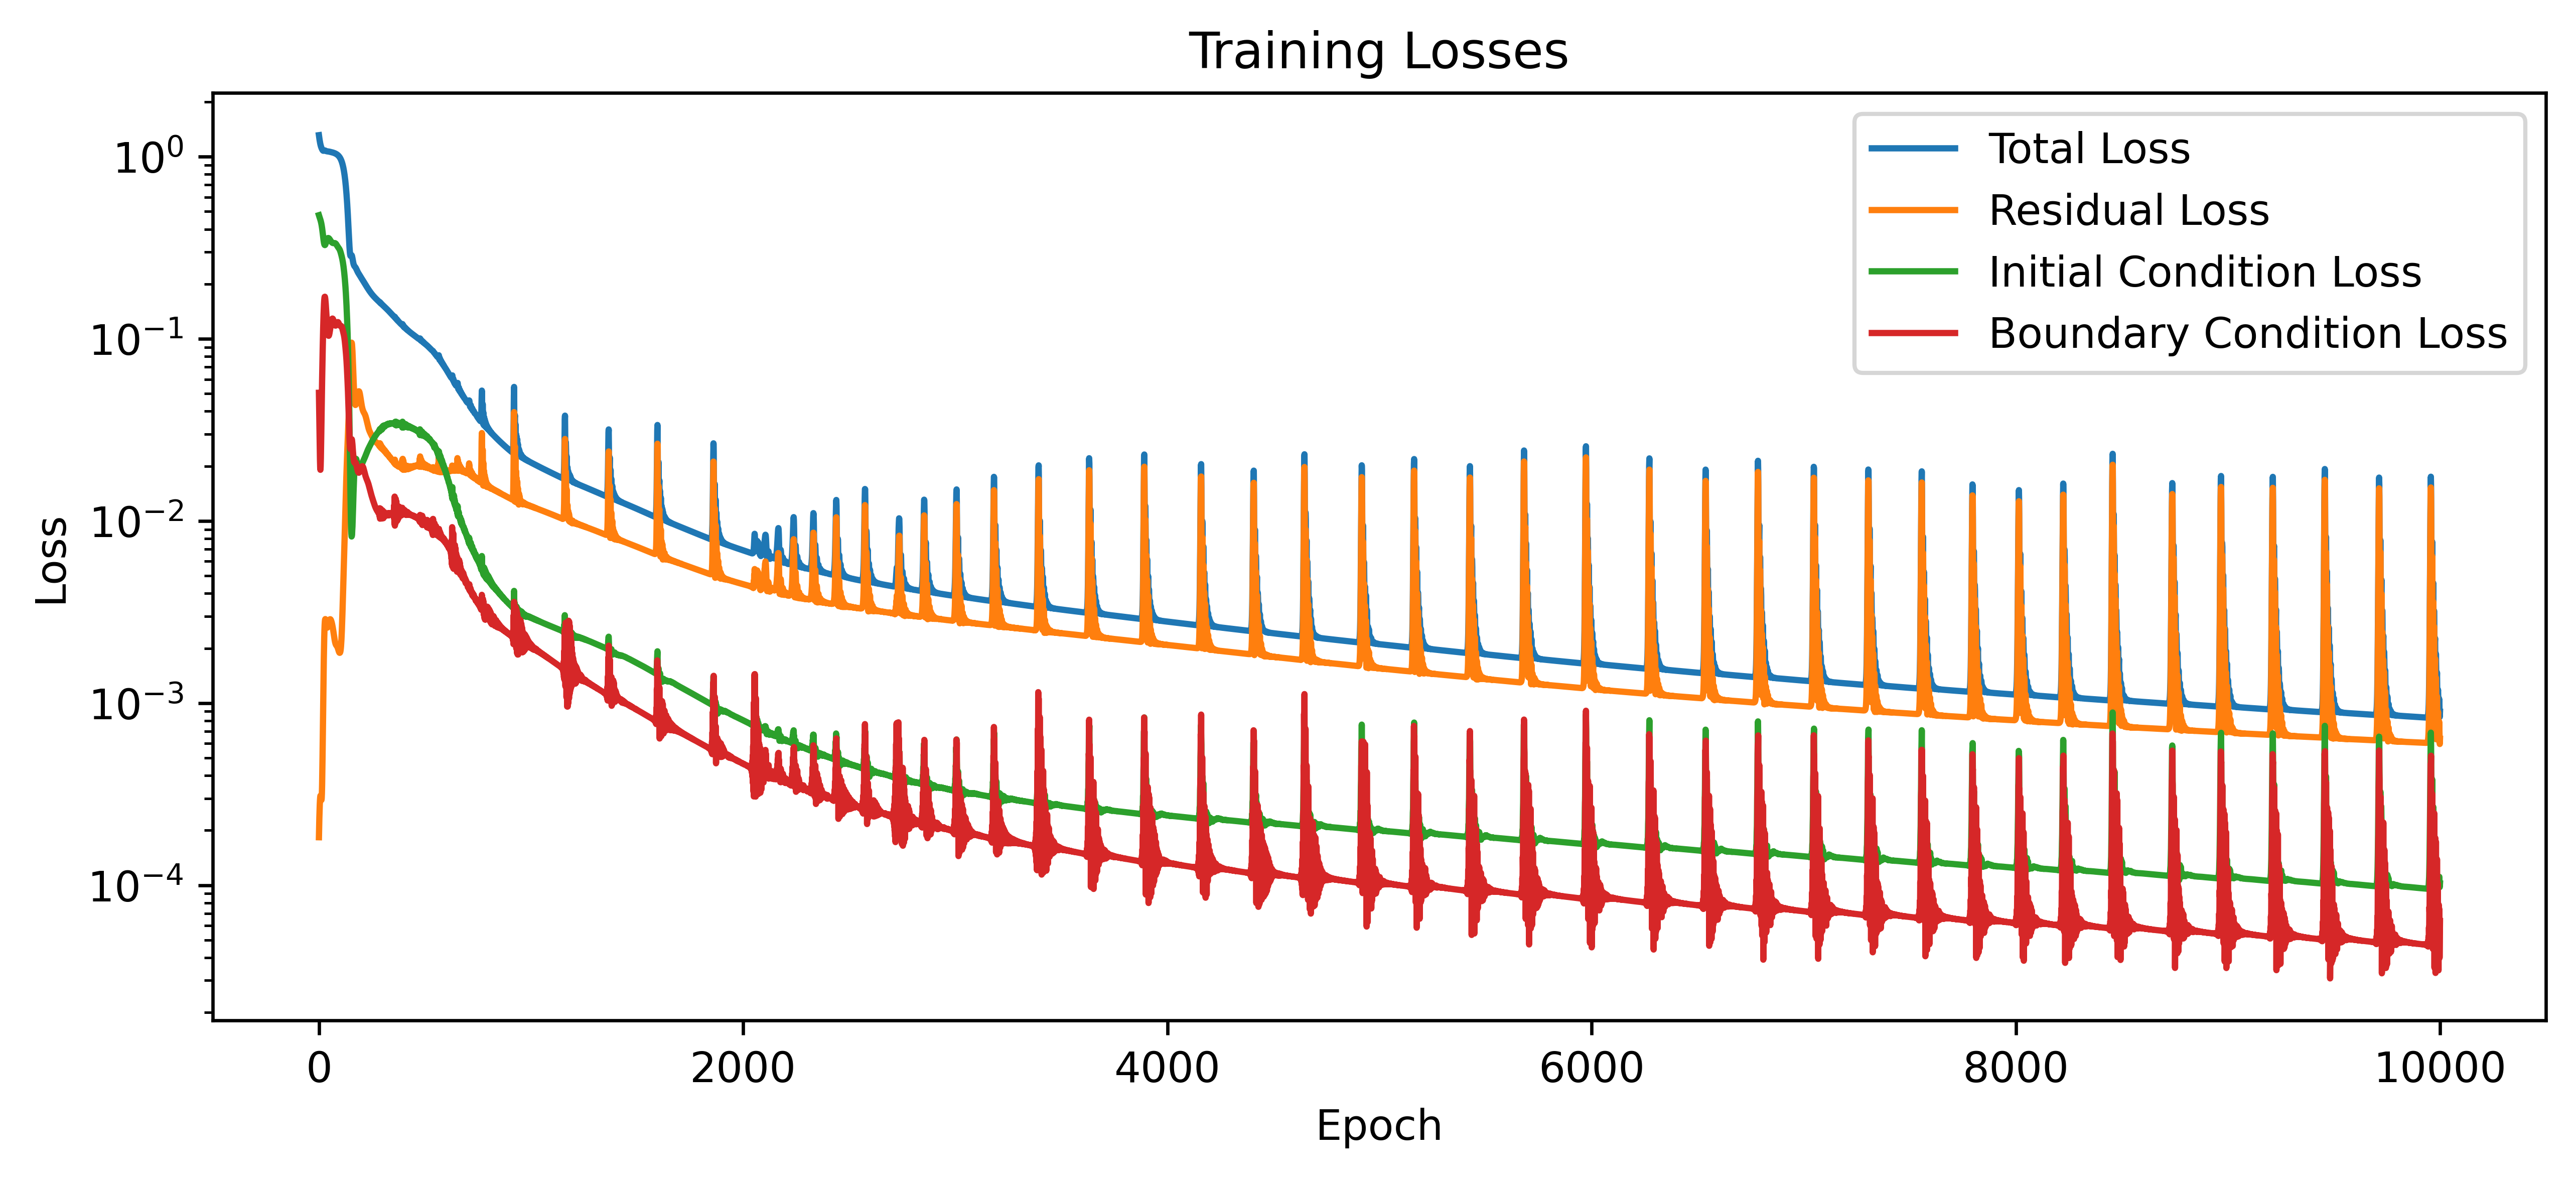

In [413]:
# Loss plot
plt.figure(figsize=(10, 4), dpi=600)
plt.plot(dict["total_loss"], label="Total Loss")
plt.plot(dict["res_loss"], label="Residual Loss")
plt.plot(dict["ic_loss"], label="Initial Condition Loss")
plt.plot(dict["bc_loss"], label="Boundary Condition Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

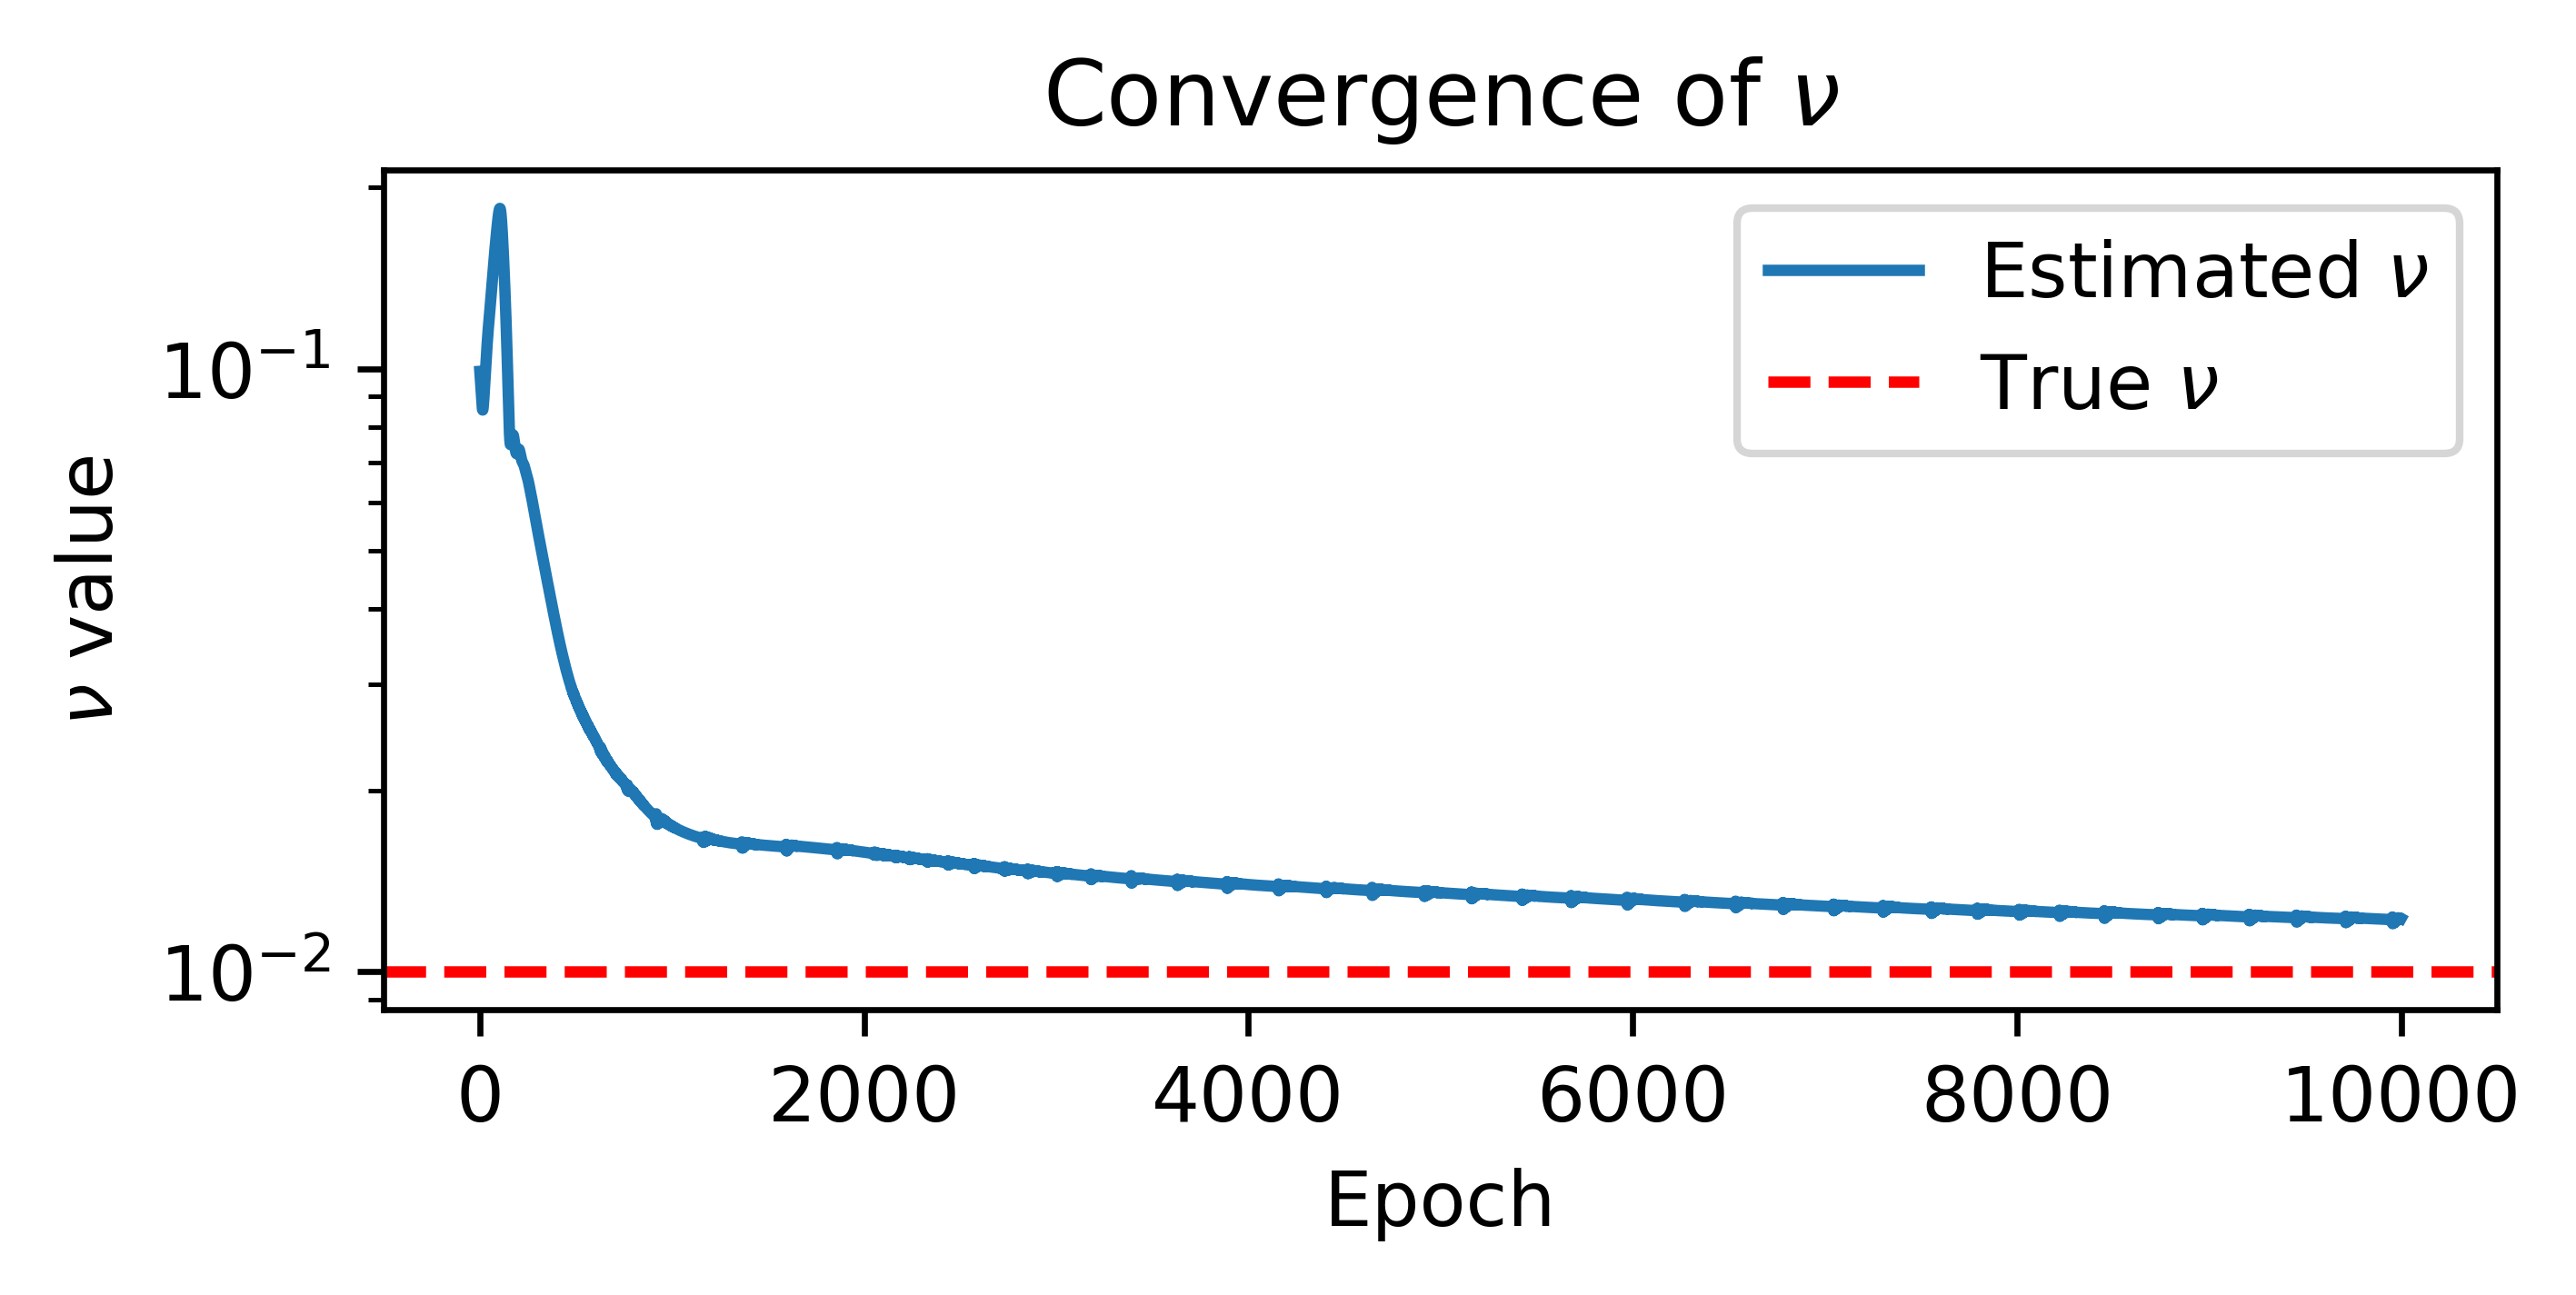

In [414]:
# Convergence nu 
plt.figure(figsize=(5, 2), dpi=600)
plt.plot(dict["nu_value"], label="Estimated $\\nu$")
plt.axhline(0.01, color='r', linestyle='--', label="True $\\nu$")
plt.xlabel("Epoch")
plt.ylabel("$\\nu$ value")
plt.yscale("log")
plt.title("Convergence of $\\nu$")
plt.legend()
plt.show()

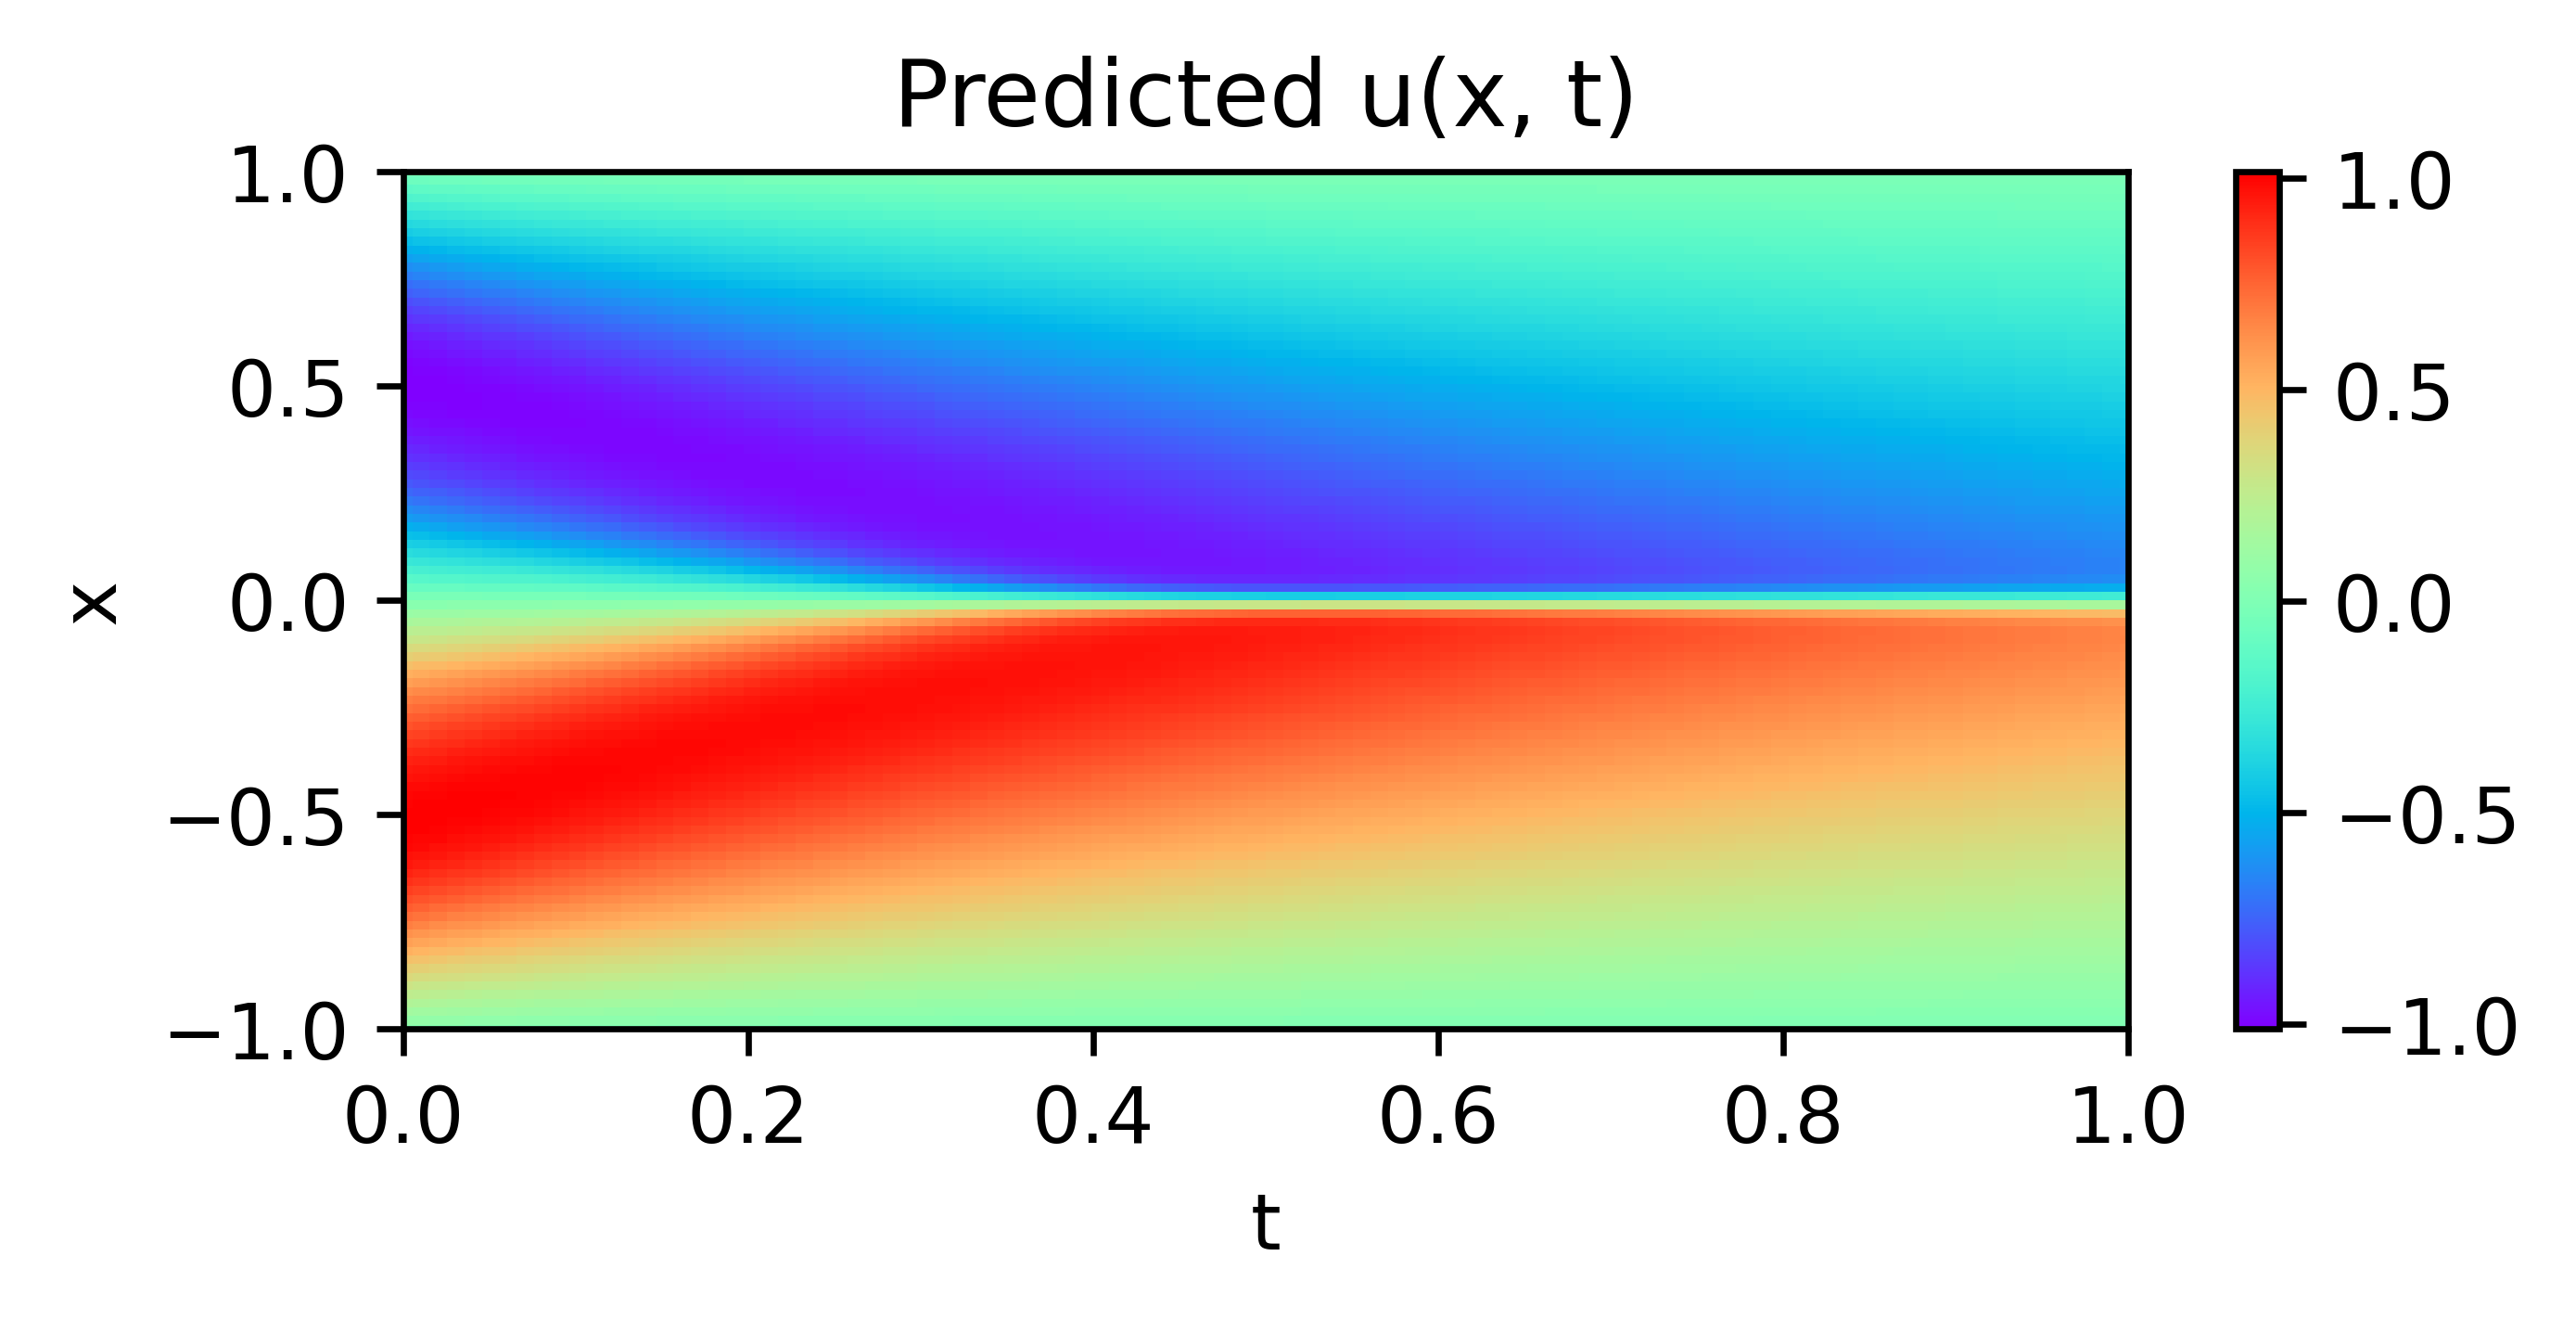

In [415]:
# Plot prediction
x_test = torch.linspace(-1, 1, 100).unsqueeze(1)
t_test = torch.linspace(0, 1, 100).unsqueeze(1)
X_test, T_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
X_test = X_test.reshape(-1, 1)
T_test = T_test.reshape(-1, 1)
with torch.no_grad():
    u_pred = net(X_test, T_test).reshape(100, 100)  

plt.figure(figsize=(5, 2), dpi=600)
plt.pcolormesh(T_test.reshape(100, 100), X_test.reshape(100, 100), u_pred, shading="auto", cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., 1.0)
plt.ylim(-1, 1)
plt.title("Predicted u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.show()

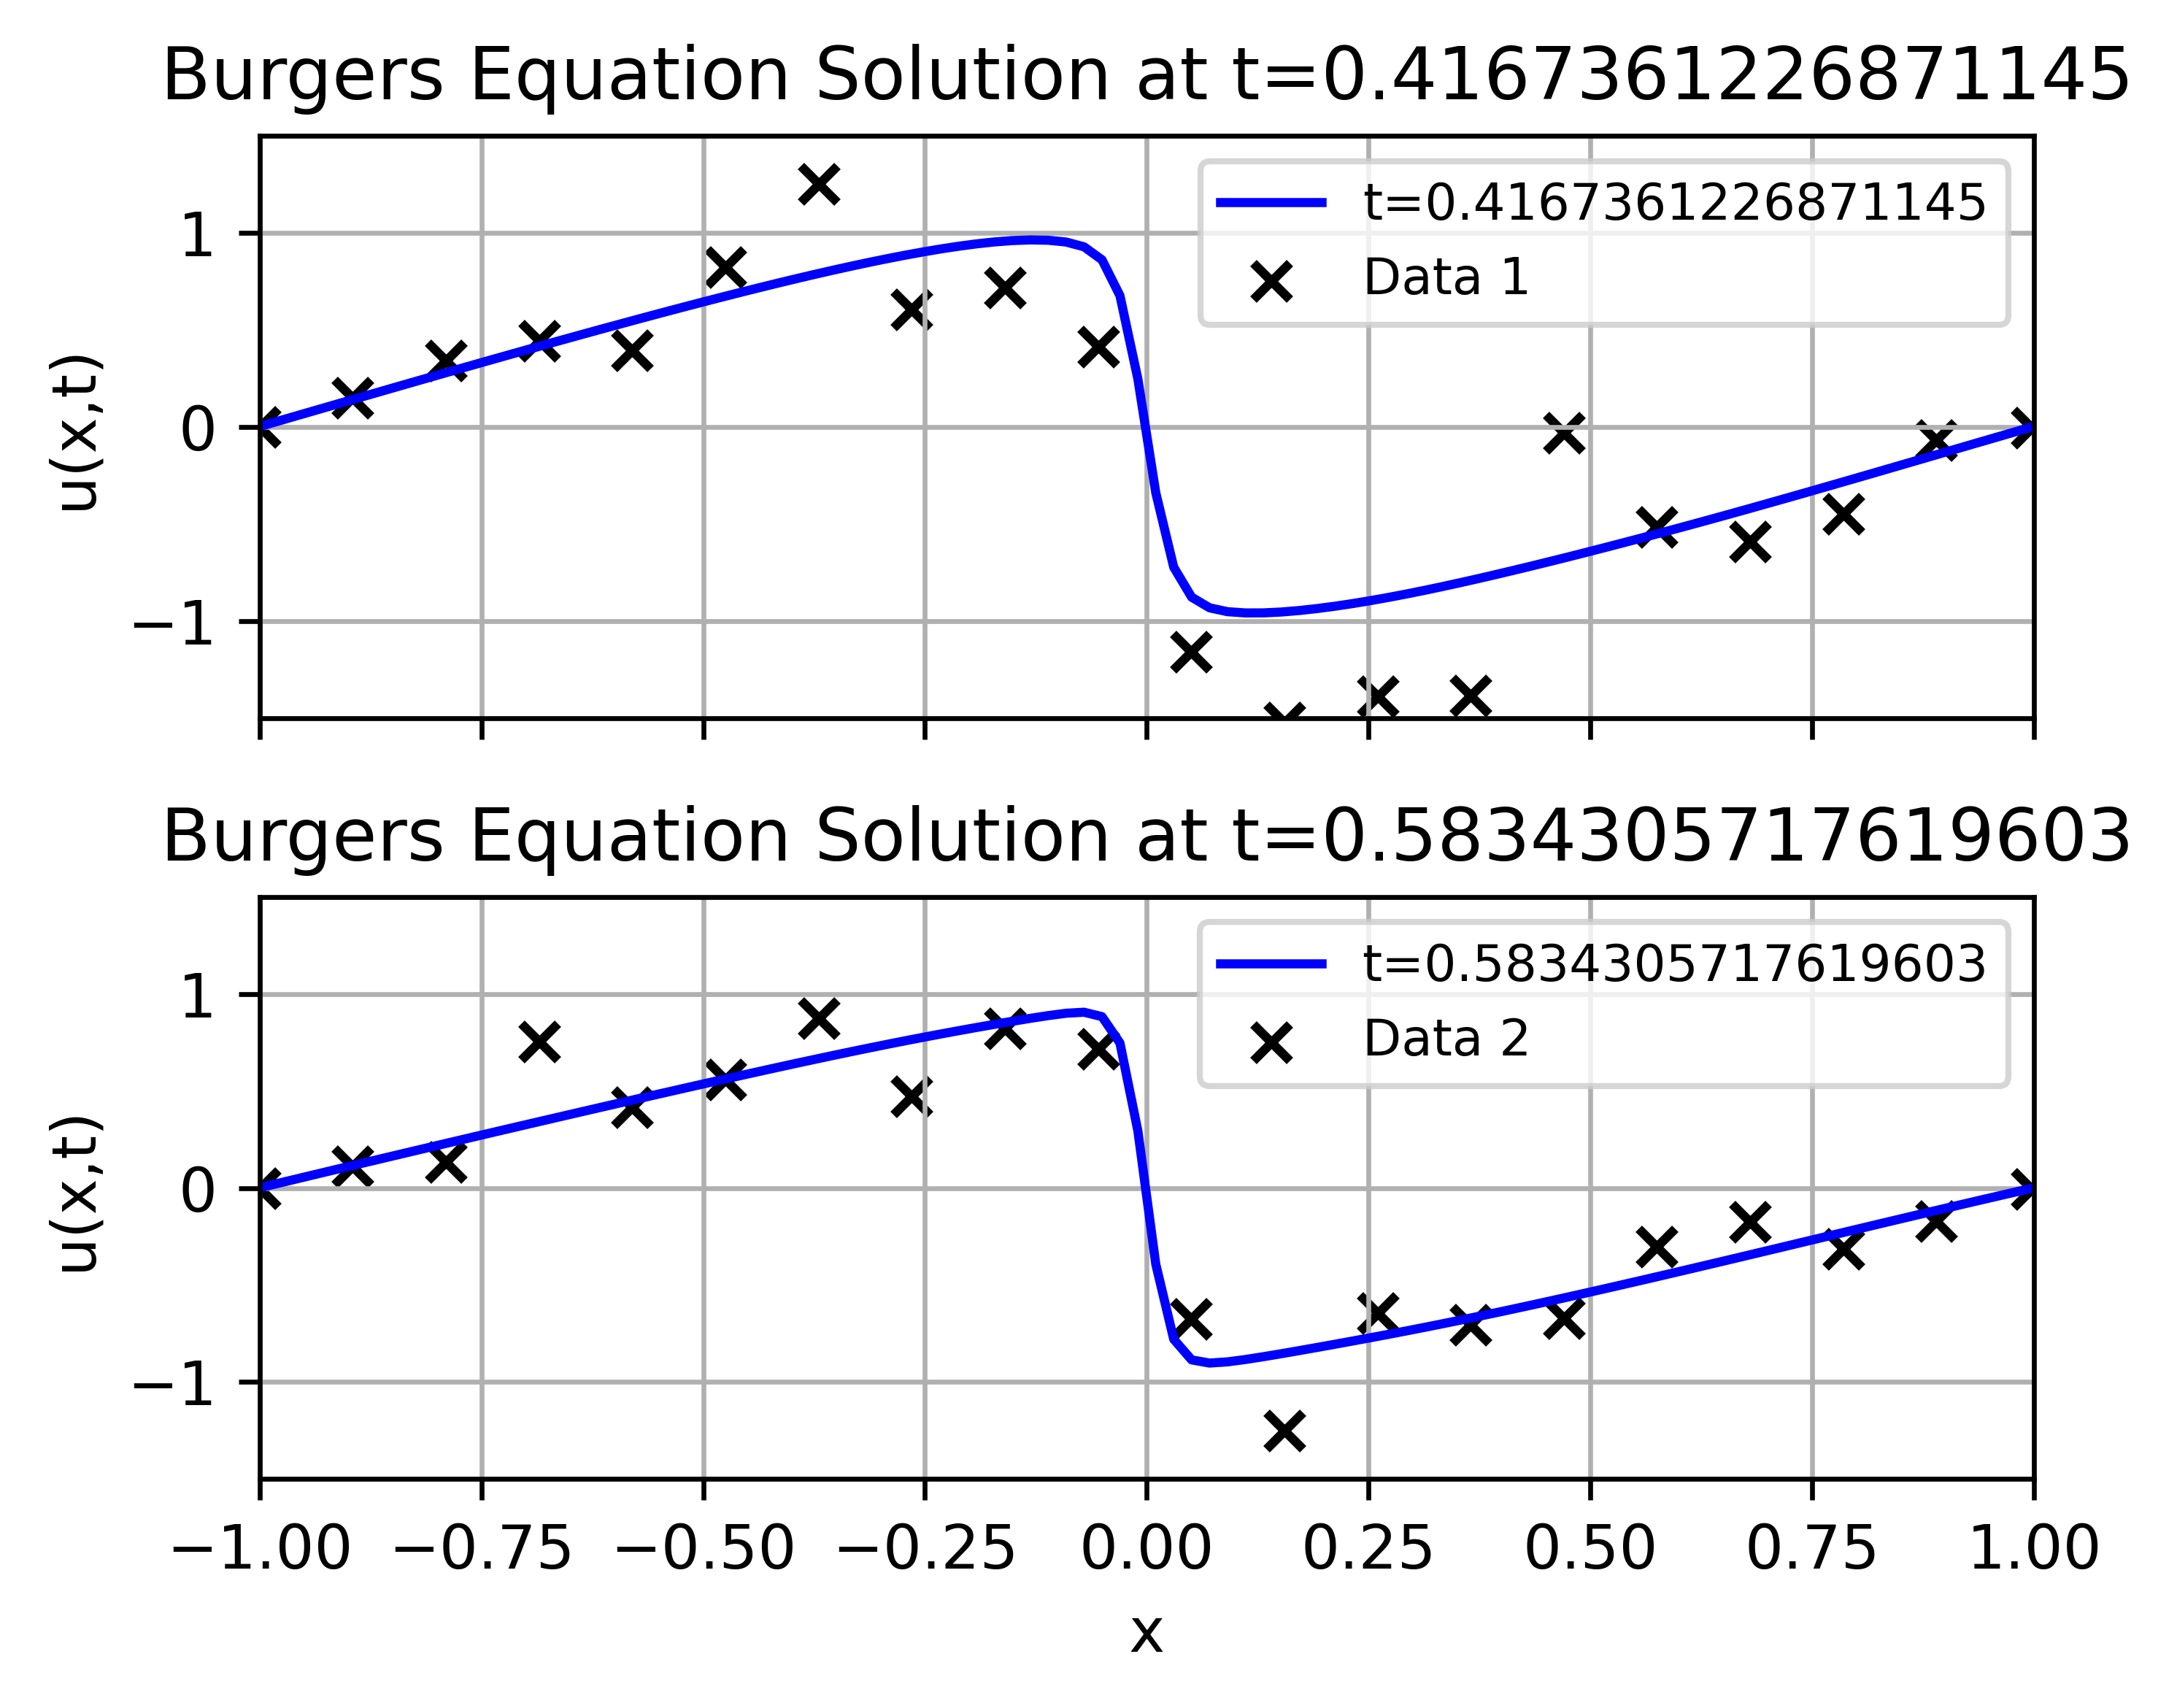

In [416]:
# pred en tp1 y tp2

x_test = torch.linspace(-1, 1, 100).unsqueeze(1)
t_test_1 = torch.tensor(tp1, dtype=torch.float32).repeat(100, 1)
t_test_2 = torch.tensor(tp2, dtype=torch.float32).repeat(100, 1)

with torch.no_grad():
    u_pred_1 = net(x_test, t_test_1).squeeze()  
    u_pred_2 = net(x_test, t_test_2).squeeze()

fig, ax = plt.subplots(2, 1, figsize=(5, 4), dpi=600, sharex=True, sharey=True)

ax[0].plot(x_test.numpy(), u_pred_1.numpy(), 'b-', label=f't={tp1}')
ax[0].scatter(X_data.numpy(), U_data_1_noisy.numpy(),  marker = 'x', color ='black', label='Data 1')
ax[0].set_title(f'Burgers Equation Solution at t={tp1}')
ax[0].set_ylabel('u(x,t)')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1.5, 1.5)
ax[0].grid(True)
ax[0].legend(loc='upper right', fontsize = 'small')

ax[1].plot(x_test.numpy(), u_pred_2.numpy(), 'b-', label=f't={tp2}')
ax[1].scatter(X_data.numpy(), U_data_2_noisy.numpy(), marker = 'x', color ='black', label='Data 2')
ax[1].set_title(f'Burgers Equation Solution at t={tp2}')
ax[1].set_xlabel('x')
ax[1].set_ylabel('u(x,t)')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1.5, 1.5)
ax[1].grid(True)
ax[1].legend(loc='upper right', fontsize = 'small')

plt.tight_layout()
plt.show()